# Time use seminar project
## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd

from DynamicSpecializationModel_post import DynamicSpecializationModelClass

In [2]:
# solve and simulate baseline model
model = DynamicSpecializationModelClass(par={'prob_birth':0.1})
%time model.solve()
%time model.simulate()

CPU times: user 954 ms, sys: 4.33 ms, total: 958 ms
Wall time: 985 ms
CPU times: user 568 ms, sys: 7.31 ms, total: 576 ms
Wall time: 643 ms


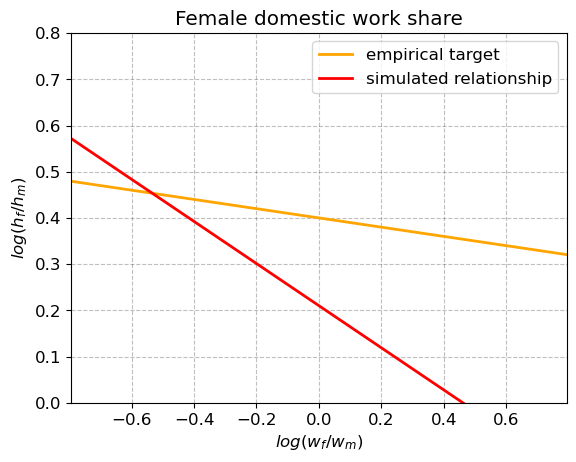

In [3]:
# plot the relationship between wages and hours in home production
model.plot()

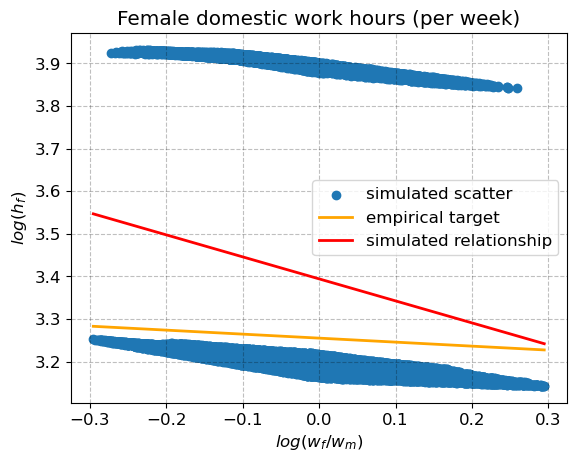

In [4]:
model.plot_female_hours()

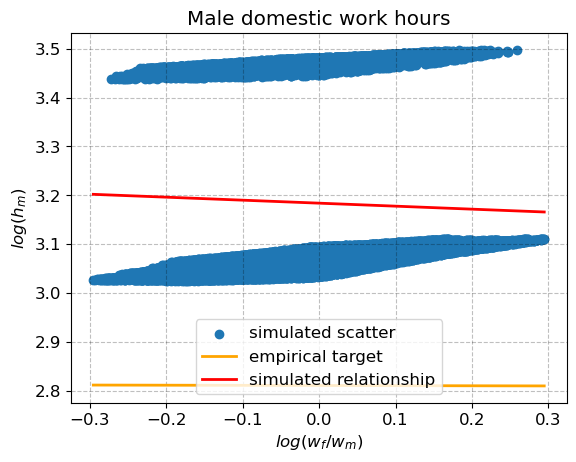

In [5]:
model.plot_male_hours()

# Solving various interations of the model

In [6]:
# solve baseline and extended model
specs = {
    'model_oct_26': {'alpha':0.797, 'alpha_n':0.030, 'sigma':0.139, 'omega_n':-0.094, 'epsilon_f':1.822, 'epsilon_m':1.878, 'wage_humcap_f':0.098, 'wage_humcap_m':0.072, 'nu':0.002, 'wage_const_f':0.000, 'wage_const_m':0.000},
    'model_nov_7': {'alpha':0.988, 'alpha_n':0.011, 'sigma':0.112, 'omega_n':-0.063, 'epsilon_f':2.391, 'epsilon_m':2.175, 'wage_humcap_f':0.100, 'wage_humcap_m':0.098, 'nu':0.004, 'wage_const_f':0.000, 'wage_const_m':0.000},
    'invented_model': {'alpha':0.988, 'alpha_n':0.011, 'sigma':0.112, 'omega_n':-0.063, 'epsilon_f':2.391, 'epsilon_m':2.175, 'wage_humcap_f':0.20, 'wage_humcap_m':0.20, 'nu':0.004, 'wage_const_f':3.0, 'wage_const_m':3.0, 'prob_birth':0.1},
    'nov_8': {'alpha':0.736, 'alpha_n':0.240, 'sigma':0.123, 'omega_n':-0.053, 'epsilon_f':1.691, 'epsilon_m':1.425, 'wage_humcap_f':0.247, 'wage_humcap_m':0.246, 'nu':0.002, 'wage_const_f':3.001, 'wage_const_m':3.070, 'epsilon_f_kids':0.681, 'epsilon_m_kids':0.221},
    'fresh_shit': {'alpha':0.860, 'alpha_n':0.048, 'sigma':0.313, 'omega_n':-0.302, 'epsilon_f':2.208, 'epsilon_m':2.046, 'wage_humcap_f':0.231, 'wage_humcap_m':0.211, 'nu':0.001, 'wage_const_f':3.014, 'wage_const_m':3.006, 'epsilon_f_kids':-0.193, 'epsilon_m_kids':0.021},
    'freshest_shit': {'alpha': 0.8815316974766287, 'alpha_n': 0.05181066696566604, 'sigma': 0.3065996569538123, 'omega_n': -0.16297912055139285, 'epsilon_f': 2.0179740838823514, 'epsilon_m': 1.9135707631606174, 'wage_humcap_f': 0.23747766853620444, 'wage_humcap_m': 0.24899017478013283, 'nu': 0.0008895465820761832, 'wage_const_f': 3.041257035645849, 'wage_const_m': 2.923096494669354, 'epsilon_f_kids': -0.29649860724420246, 'epsilon_m_kids': 0.019849083717954165},
    'no_wage': {'alpha': 0.9175579976064591, 'alpha_n': 0.07917241123146314, 'sigma': 0.12625036081937915, 'omega_n': -0.14947763839119987, 'epsilon_f': 2.2369437496846913, 'epsilon_m': 1.9865940792916605, 'wage_humcap_f': 0.004889017642282528, 'wage_humcap_m': 0.053252265524500436, 'nu': 0.003500121128937236, 'wage_const_f': -0.0018414888277021556, 'wage_const_m': -0.0053044414643513985, 'epsilon_f_kids': 0.027592604806535165, 'epsilon_m_kids': 0.05999543862942529}}

models = dict()
for name,spec in specs.items():
    models[name] = DynamicSpecializationModelClass()
    
    for par_name,val in spec.items():
        setattr(models[name].par,par_name,val)

    models[name].solve()
    models[name].simulate()

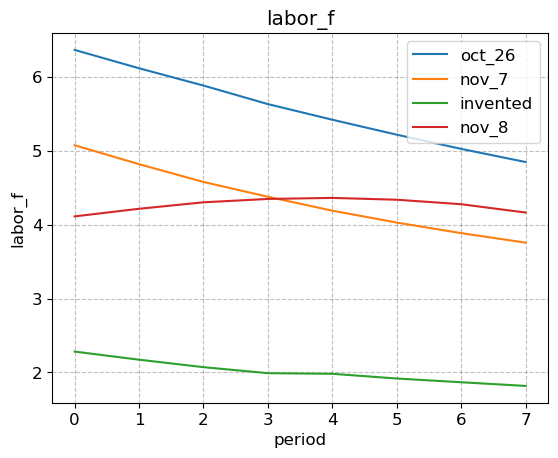

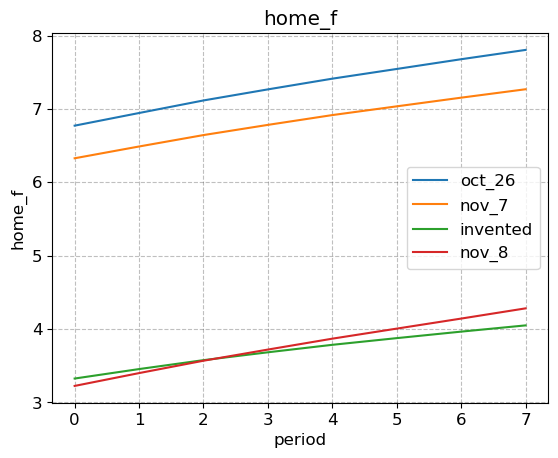

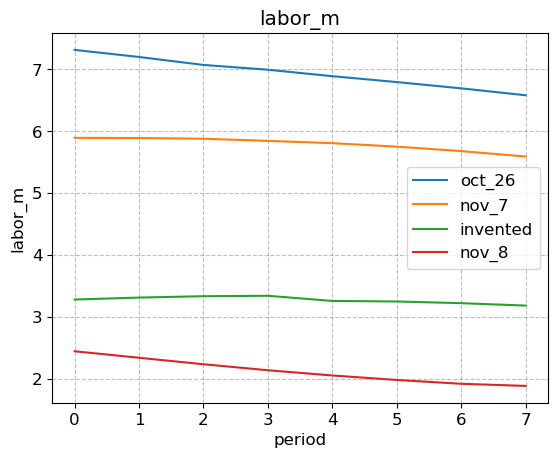

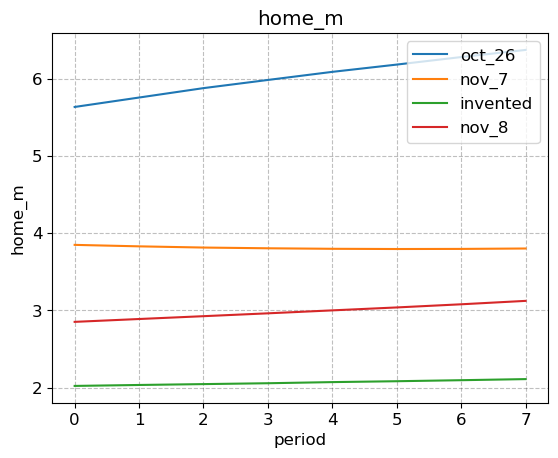

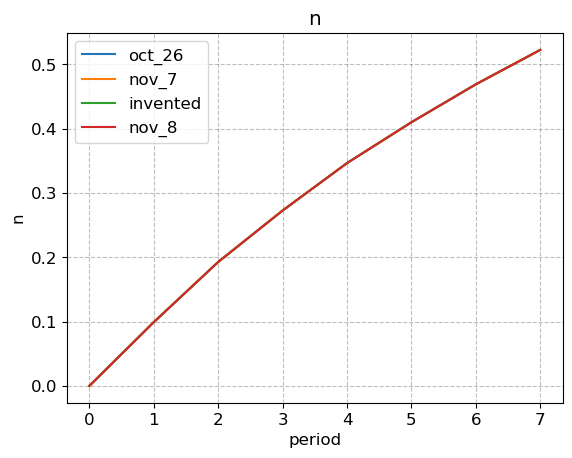

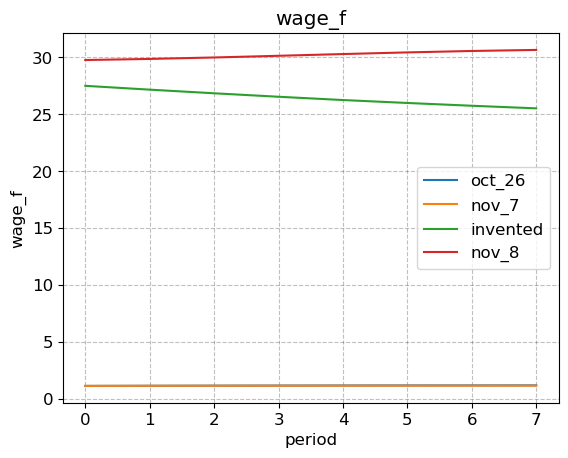

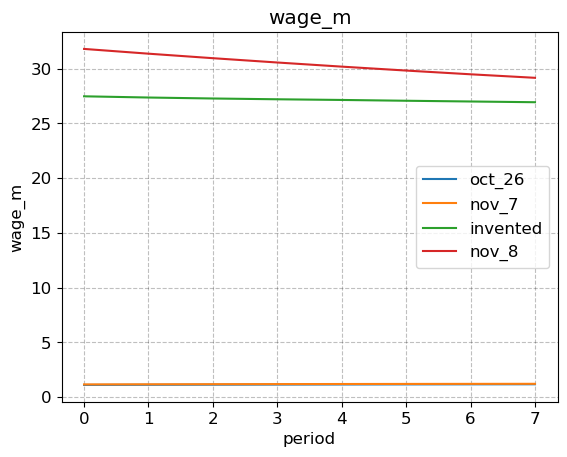

In [7]:
# Plot age profiles in both
for outcome in ('labor_f','home_f','labor_m','home_m','n', 'wage_f', 'wage_m'):
    fig, ax = plt.subplots()
    outcome_oct_26 = np.mean(getattr(models['model_oct_26'].sim,outcome),axis=0)
    outcome_nov_7 = np.mean(getattr(models['model_nov_7'].sim,outcome),axis=0)
    outcome_invented = np.mean(getattr(models['invented_model'].sim,outcome),axis=0)
    outcome_nov_8 = np.mean(getattr(models['nov_8'].sim,outcome),axis=0)

    ax.plot(outcome_oct_26,label='oct_26')
    ax.plot(outcome_nov_7,label='nov_7')
    ax.plot(outcome_invented,label='invented')
    ax.plot(outcome_nov_8,label='nov_8')
    ax.set(title=outcome,xlabel='period',ylabel=outcome);
    ax.legend()

## Calculating some moments from the model

In [8]:
# the model is from now on the extended version
model = models['no_wage'].copy()

In [44]:
def calculate_event_mean_new(model, outcome_str, min_time=-5, max_time=5):
    """
    Calculate average outcome across time since birth, in levels.

    Parameters:
    model (object): The model object containing parameters and simulation results.
    outcome_str (str): The name of the outcome variable to analyze.
    min_time (int): Minimum time (relative to birth) to include in the event window.
    max_time (int): Maximum time (relative to birth) to include in the event window.

    Returns:
    tuple: (event_grid, event_outcome) - time grid and average outcomes at each time.
    """
    par = model.par
    sim = model.sim

    # Time periods
    periods = np.tile([t for t in range(par.simT)], (par.simN, 1))
    time_of_birth = np.max(periods * sim.birth, axis=1)

    # Identify individuals who have a birth event
    has_birth = time_of_birth > 0
    time_of_birth[~has_birth] = -1000  # For those who never have a child
    time_of_birth = np.transpose(np.tile(time_of_birth, (par.simT, 1)))

    # Time since birth
    time_since_birth = periods - time_of_birth

    # Get the outcome variable (e.g., domestic or market work)
    outcome = getattr(sim, outcome_str)

    # Calculate event-study means
    event_grid = np.arange(min_time, max_time + 1)
    event_outcome = np.full(event_grid.size, np.nan)
    for t, time in enumerate(event_grid):
        event_outcome[t] = np.mean(outcome[time_since_birth == time])

    return event_grid, event_outcome


In [9]:
def calculate_event_mean(model,outcome_str,min_time=-5,max_time=5,relative=-1,pct=True):
    ''' calculate average outcome across time since birth '''

    par = model.par
    sim = model.sim

    # time since birth
    periods = np.tile([t for t in range(par.simT)],(par.simN,1))
    time_of_birth = np.max(periods * sim.birth, axis=1)

    I = time_of_birth>0
    time_of_birth[~I] = -1000 # never has a child
    time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))

    time_since_birth = periods - time_of_birth

    # event-study mean
    outcome = getattr(sim,outcome_str)
    event_grid = np.arange(min_time,max_time+1)

    event_outcome = np.nan + np.zeros(event_grid.size)
    for t,time in enumerate(event_grid):
        event_outcome[t] = np.mean(outcome[time_since_birth==time])

    # relative to period before birth
    if relative is not None:
        event_outcome_rel = event_outcome - event_outcome[event_grid==relative]
        if pct:
            event_outcome = event_outcome_rel/event_outcome[event_grid==relative]
        else:
            event_outcome = event_outcome_rel

    # return the indicators of distance to event along with the average outcome for each time periode            
    return event_grid,event_outcome

In [10]:
def calculate_event_levels(model, outcome_str, pre_range=(-5, -1), post_range=(1, 5)):
    """
    Calculate pre-birth average, the jump at childbirth, and post-birth average for an outcome.

    Parameters:
    model (object): The model object containing parameters and simulation results.
    outcome_str (str): The name of the outcome variable to analyze.
    pre_range (tuple): The range of time periods to calculate the pre-birth average (inclusive).
    post_range (tuple): The range of time periods to calculate the post-birth average (inclusive).

    Returns:
    tuple: (pre_avg, jump, post_avg)
    """
    par = model.par
    sim = model.sim

    # Time periods
    periods = np.tile([t for t in range(par.simT)], (par.simN, 1))
    time_of_birth = np.max(periods * sim.birth, axis=1)

    # Identify individuals who have a birth event
    I = time_of_birth > 0
    time_of_birth[~I] = -1000  # Never has a child
    time_of_birth = np.transpose(np.tile(time_of_birth, (par.simT, 1)))

    # Time since birth
    time_since_birth = periods - time_of_birth

    # Get the outcome variable
    outcome = getattr(sim, outcome_str)

    # Pre-birth average
    pre_mask = (time_since_birth >= pre_range[0]) & (time_since_birth <= pre_range[1])
    pre_avg = np.mean(outcome[pre_mask])

    # Jump at childbirth (period 0)
    jump_mask = (time_since_birth == 0)
    jump = np.mean(outcome[jump_mask]) - pre_avg

    # Post-birth average
    post_mask = (time_since_birth >= post_range[0]) & (time_since_birth <= post_range[1])
    post_avg = np.mean(outcome[post_mask])

    return pre_avg, jump, post_avg


In [11]:
def calculate_time_mean(model, outcome_str):
    ''' Calculate the average outcome across time periods '''

    sim = model.sim
    par = model.par

    # Extract the outcome variable over time
    outcome = getattr(sim, outcome_str)

    # Calculate the average outcome for each time period
    time_grid = np.arange(par.simT)
    time_outcome = np.mean(outcome, axis=0)

    # Return the time grid along with the average outcome for each time period
    return time_grid, time_outcome


In [12]:
def calculate_overall_mean(model, outcome_str):
    ''' Calculate the overall average of the outcome across all time periods '''

    sim = model.sim

    # Extract the outcome variable over time
    outcome = getattr(sim, outcome_str)

    # Calculate the overall average outcome across all time periods and simulations
    overall_mean = np.mean(outcome)

    # Return the overall mean
    return overall_mean

# Calculate the average labor supply
avg_labor_f = calculate_overall_mean(model, 'labor_f')
avg_labor_m = calculate_overall_mean(model, 'labor_m')
print(f'Average female labor supply is {avg_labor_f:.2f}')
print(f'Average male labor supply is {avg_labor_m:.2f}')

# calculate average wages
avg_wage_f = calculate_overall_mean(model, 'wage_f')
avg_wage_m = calculate_overall_mean(model, 'wage_m')
print(f'Average female wage is {avg_wage_f:.2f}')
print(f'Average male wage is {avg_wage_m:.2f}')


Average female labor supply is 3.75
Average male labor supply is 6.27
Average female wage is 1.01
Average male wage is 1.10


In [13]:
# test the function with hours in home production
calculate_time_mean(model, 'home_f')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([6.37816555, 6.70593343, 7.01674781, 7.2809663 , 7.52572711,
        7.73799721, 7.93540609, 8.11565541]))

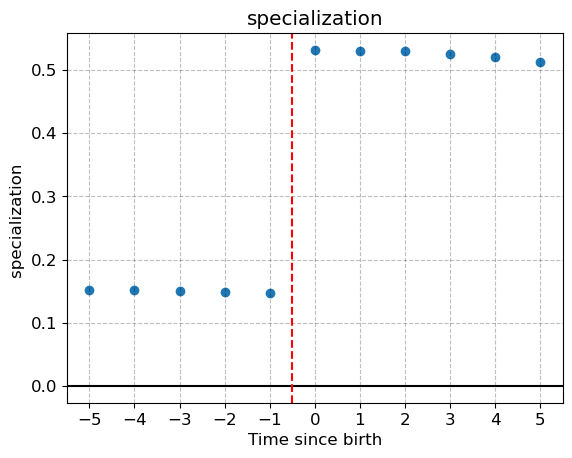

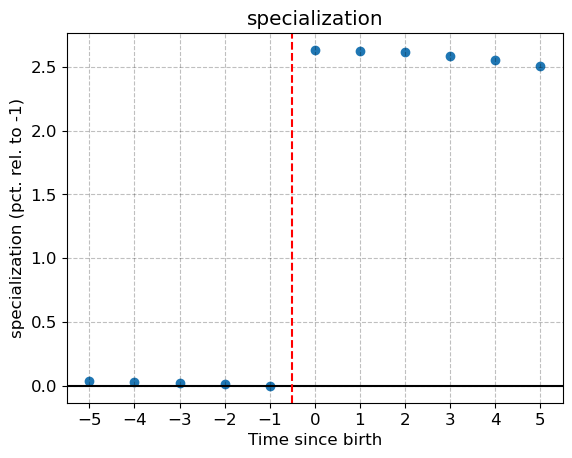

In [14]:
for relative in (None,-1):
    for val in ('specialization',):
            
        event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=relative,pct=True)
        
        rel = ''
        if relative is not None:
            rel = '(pct. rel. to -1)'
        fig, ax = plt.subplots()
        ax.scatter(event_grid,event_rel)
        ax.axhline(y=0,color='black')
        ax.axvline(x=-0.5,color='red',linestyle='dashed')
        ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} {rel}',xticks=event_grid);

## Structural estimation with SMM

In [15]:
moms_data = pd.DataFrame({
    'moment': [
        'constant_share', 'slope_share',
        'constant_m', 'slope_m', 'constant_f', 'slope_f',
        'pre_h_f', 'jump_h_f', 'post_h_f',
        'pre_h_m', 'jump_h_m', 'post_h_m',
        'pre_l_f', 'jump_l_f', 'post_l_f',
        'pre_l_m', 'jump_l_m', 'post_l_m',
    ],
    'value': [  # Replace these with the actual data moments
        0.4, -0.1, 2.811, 0.003, 3.255, -0.094,
        22.5, 10.0, 30.0,  # Female domestic work (pre, jump, post)
        10.5, -5.0, 8.0,   # Male domestic work (pre, jump, post)
        20.0, -8.0, 15.0,  # Female market work (pre, jump, post)
        40.0, 5.0, 42.0,   # Male market work (pre, jump, post)
    ]
})



In [16]:
# Load the Stata moments
stata_moments = pd.read_csv("Moments_Data.csv")

# Update the Python `moms_data`
for index, row in stata_moments.iterrows():
    moms_data.loc[moms_data['moment'] == 'pre_h_f', 'value'] = row['pre_h_f']
    moms_data.loc[moms_data['moment'] == 'jump_h_f', 'value'] = row['jump_h_f']
    moms_data.loc[moms_data['moment'] == 'post_h_f', 'value'] = row['post_h_f']
    moms_data.loc[moms_data['moment'] == 'pre_h_m', 'value'] = row['pre_h_m']
    moms_data.loc[moms_data['moment'] == 'jump_h_m', 'value'] = row['jump_h_m']
    moms_data.loc[moms_data['moment'] == 'post_h_m', 'value'] = row['post_h_m']
    moms_data.loc[moms_data['moment'] == 'pre_l_f', 'value'] = row['pre_l_f']
    moms_data.loc[moms_data['moment'] == 'jump_l_f', 'value'] = row['jump_l_f']
    moms_data.loc[moms_data['moment'] == 'post_l_f', 'value'] = row['post_l_f']
    moms_data.loc[moms_data['moment'] == 'pre_l_m', 'value'] = row['pre_l_m']
    moms_data.loc[moms_data['moment'] == 'jump_l_m', 'value'] = row['jump_l_m']
    moms_data.loc[moms_data['moment'] == 'post_l_m', 'value'] = row['post_l_m']

In [17]:
# To access the data values for optimization:
moms_data_values = moms_data['value'].to_numpy()

# Example: print labeled moments
print(moms_data)

            moment      value
0   constant_share   0.400000
1      slope_share  -0.100000
2       constant_m   2.811000
3          slope_m   0.003000
4       constant_f   3.255000
5          slope_f  -0.094000
6          pre_h_f   3.265729
7         jump_h_f  10.340913
8         post_h_f   9.567722
9          pre_h_m   2.257335
10        jump_h_m   4.149493
11        post_h_m   4.467527
12         pre_l_f   5.141663
13        jump_l_f   1.421732
14        post_l_f   2.450078
15         pre_l_m   6.883491
16        jump_l_m   6.793361
17        post_l_m   6.924767


In [18]:
def calculate_level_moments(model, outcome_str, pre_range=(-5, -1), post_range=(1, 5)):
    """
    Calculate pre-birth average, the jump at childbirth, and post-birth average for an outcome.

    Parameters:
    model (object): The model object containing parameters and simulation results.
    outcome_str (str): The name of the outcome variable to analyze.
    pre_range (tuple): Range for pre-birth average (inclusive).
    post_range (tuple): Range for post-birth average (inclusive).

    Returns:
    tuple: (pre_avg, jump, post_avg)
    """
    par = model.par
    sim = model.sim

    # Time periods
    periods = np.tile([t for t in range(par.simT)], (par.simN, 1))
    time_of_birth = np.max(periods * sim.birth, axis=1)

    # Identify individuals who have a birth event
    has_birth = time_of_birth > 0
    time_of_birth[~has_birth] = -1000  # For those who never have a child
    time_of_birth = np.transpose(np.tile(time_of_birth, (par.simT, 1)))

    # Time since birth
    time_since_birth = periods - time_of_birth

    # Get the outcome variable (e.g., domestic or market work)
    outcome = getattr(sim, outcome_str)

    # Pre-birth average
    pre_mask = (time_since_birth >= pre_range[0]) & (time_since_birth <= pre_range[1])
    pre_avg = np.mean(outcome[pre_mask])

    # Jump at childbirth (period 0)
    jump_mask = (time_since_birth == 0)
    jump = np.mean(outcome[jump_mask])

    # Post-birth average
    post_mask = (time_since_birth >= post_range[0]) & (time_since_birth <= post_range[1])
    post_avg = np.mean(outcome[post_mask])

    return pre_avg, jump, post_avg

# Test the function with hours in home production
calculate_level_moments(model, 'labor_m')



(6.331962032349042, 6.365847585017264, 6.271649172678964)

In [41]:
def calc_moments(model):
    """
    Calculate all model moments based on simulation results.
    """
    # Domestic work (h) and market work (l) moments
    pre_h_f, jump_h_f, post_h_f = calculate_level_moments(model, 'home_f')
    pre_h_m, jump_h_m, post_h_m = calculate_level_moments(model, 'home_m')
    pre_l_f, jump_l_f, post_l_f = calculate_level_moments(model, 'labor_f')
    pre_l_m, jump_l_m, post_l_m = calculate_level_moments(model, 'labor_m')

    # Average market work and wages
    #avg_l_f = calculate_overall_mean(model, 'labor_f')
    #avg_l_m = calculate_overall_mean(model, 'labor_m')
    #avg_wage_f = calculate_overall_mean(model, 'wage_f')
    #avg_wage_m = calculate_overall_mean(model, 'wage_m')

    # Female/male share regression coefficients
    constant_share, slope_share = model.regress()

    # Male home production regression coefficients
    constant_m, slope_m = model.regress_male()

    # Female home production regression coefficients
    constant_f, slope_f = model.regress_female()

    # Combine all moments into a numpy array
    return np.array([
        constant_share, slope_share,
        constant_m, slope_m, constant_f, slope_f,
        pre_h_f, jump_h_f, post_h_f,
        pre_h_m, jump_h_m, post_h_m,
        pre_l_f, jump_l_f, post_l_f,
        pre_l_m, jump_l_m, post_l_m,
    ])

# Calculate model moments
moms_model = calc_moments(model)
#print(moms_model)

# print moments with labels
moms_labels = [
    'constant_share', 'slope_share',
    'constant_m', 'slope_m', 'constant_f', 'slope_f',
    'pre_h_f', 'jump_h_f', 'post_h_f',
    'pre_h_m', 'jump_h_m', 'post_h_m',
    'pre_l_f', 'jump_l_f', 'post_l_f',
    'pre_l_m', 'jump_l_m', 'post_l_m',
]
print(pd.DataFrame({'moment': moms_labels, 'value': moms_model, 'data': moms_data_values}))


[ 0.41600278 -0.16180152  3.47268406  0.08087897  3.88868685 -0.08092256
  6.18198065  9.6847999   9.66915404  4.72230894  4.19547811  4.19491266
  4.67137576  1.18679111  1.36582705  6.17059112  6.14701253  5.96632304]
            moment     value       data
0   constant_share  0.416003   0.400000
1      slope_share -0.161802  -0.100000
2       constant_m  3.472684   2.811000
3          slope_m  0.080879   0.003000
4       constant_f  3.888687   3.255000
5          slope_f -0.080923  -0.094000
6          pre_h_f  6.181981   3.265729
7         jump_h_f  9.684800  10.340913
8         post_h_f  9.669154   9.567722
9          pre_h_m  4.722309   2.257335
10        jump_h_m  4.195478   4.149493
11        post_h_m  4.194913   4.467527
12         pre_l_f  4.671376   5.141663
13        jump_l_f  1.186791   1.421732
14        post_l_f  1.365827   2.450078
15         pre_l_m  6.170591   6.883491
16        jump_l_m  6.147013   6.793361
17        post_l_m  5.966323   6.924767


In [20]:
def obj(theta, theta_names, model, moms_data, do_print=False):
    """
    Objective function for the parameter optimization.

    Parameters:
    theta (array-like): Current parameter values.
    theta_names (list): List of parameter names.
    model (object): The model object.
    moms_data (pandas.DataFrame): Data moments with labels and values.
    do_print (bool): If True, print the parameters and squared sum of differences.

    Returns:
    float: Sum of squared differences between simulated and data moments.
    """
    # a. Update model parameters
    for i, name in enumerate(theta_names):
        setattr(model.par, name, theta[i])

    # b. Solve and simulate the model
    model.solve()
    model.simulate()

    # c. Calculate model moments
    moms_sim = calc_moments(model)  # Returns a NumPy array

    # d. Extract data moments as NumPy array
    moms_data_values = moms_data['value'].to_numpy()

    # e. Calculate moment differences
    diff = moms_sim - moms_data_values  # Both are now NumPy arrays
    sqsum = np.sum(diff**2)

    # f. Print parameters and objective value (if requested)
    if do_print:
        print("Parameters:", {name: theta[i] for i, name in enumerate(theta_names)})
        print(f"Squared Sum: {sqsum:.8f}")

    # g. Return squared differences
    return sqsum


In [21]:
# set parameters and initial values
theta_names = ('alpha','alpha_n','sigma','omega_n','epsilon_f','epsilon_m','wage_humcap_f','wage_humcap_m','nu', 'wage_const_f', 'wage_const_m', 'epsilon_f_kids', 'epsilon_m_kids')
# Define initial parameter values based on Nov 7 estimation results
theta_init = np.array([0.85, 0.05, 0.3, -0.16, 2.0, 1.96, 0.1, 0.1, 0.0008659026225391137, 0.0,0.0, -0.3, 0.02])
#{'alpha': 0.8641506210467227, 'alpha_n': 0.057671354877293676, 'sigma': 0.32175314646359876, 'omega_n': -0.16186198409865757, 'epsilon_f': 2.082715457262152, 'epsilon_m': 1.9622930263541662, 'wage_humcap_f': 0.2586801058672381, 'wage_humcap_m': 0.24505881724502848, 'nu': 0.0008659026225391137, 'wage_const_f': 2.979080404315563, 'wage_const_m': 2.9361670958853647, 'epsilon_f_kids': -0.2581663148363688, 'epsilon_m_kids': 0.02193040384114739}

#old initial values
#theta_init = np.array([0.957,0.027,0.109,-0.095, 1.808,1.711,0.094,0.075,0.008, 0.00000000005, 0.00000000005, -0.5, 0.01])

obj_init = obj(theta_init,theta_names,model,moms_data,do_print=True)

Parameters: {'alpha': 0.85, 'alpha_n': 0.05, 'sigma': 0.3, 'omega_n': -0.16, 'epsilon_f': 2.0, 'epsilon_m': 1.96, 'wage_humcap_f': 0.1, 'wage_humcap_m': 0.1, 'nu': 0.0008659026225391137, 'wage_const_f': 0.0, 'wage_const_m': 0.0, 'epsilon_f_kids': -0.3, 'epsilon_m_kids': 0.02}
Squared Sum: 309.72473301


In [39]:
# estimate using a numerical solver
obj_func = lambda theta: obj(theta,theta_names,model,moms_data,do_print=True)

def smm_calc(do_calcs):
    if do_calcs == True:
        est = minimize(obj_func,theta_init,method='nelder-mead')
    else:
        est = f'not today'
    return est

smm_calc(True)

Parameters: {'alpha': 0.85, 'alpha_n': 0.05, 'sigma': 0.3, 'omega_n': -0.16, 'epsilon_f': 2.0, 'epsilon_m': 1.96, 'wage_humcap_f': 0.1, 'wage_humcap_m': 0.1, 'nu': 0.0008659026225391137, 'wage_const_f': 0.0, 'wage_const_m': 0.0, 'epsilon_f_kids': -0.3, 'epsilon_m_kids': 0.02}
Squared Sum: 309.72473301
Parameters: {'alpha': 0.8925, 'alpha_n': 0.05, 'sigma': 0.3, 'omega_n': -0.16, 'epsilon_f': 2.0, 'epsilon_m': 1.96, 'wage_humcap_f': 0.1, 'wage_humcap_m': 0.1, 'nu': 0.0008659026225391137, 'wage_const_f': 0.0, 'wage_const_m': 0.0, 'epsilon_f_kids': -0.3, 'epsilon_m_kids': 0.02}
Squared Sum: 326.85184132
Parameters: {'alpha': 0.85, 'alpha_n': 0.052500000000000005, 'sigma': 0.3, 'omega_n': -0.16, 'epsilon_f': 2.0, 'epsilon_m': 1.96, 'wage_humcap_f': 0.1, 'wage_humcap_m': 0.1, 'nu': 0.0008659026225391137, 'wage_const_f': 0.0, 'wage_const_m': 0.0, 'epsilon_f_kids': -0.3, 'epsilon_m_kids': 0.02}
Squared Sum: 309.99301273
Parameters: {'alpha': 0.85, 'alpha_n': 0.05, 'sigma': 0.315, 'omega_n': -

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 19.202783658094788
             x: [ 9.115e-01  8.802e-02 ...  1.238e-01  6.976e-02]
           nit: 1125
          nfev: 2600
 final_simplex: (array([[ 9.115e-01,  8.802e-02, ...,  1.238e-01,
                         6.976e-02],
                       [ 9.115e-01,  8.802e-02, ...,  1.238e-01,
                         6.976e-02],
                       ...,
                       [ 9.115e-01,  8.802e-02, ...,  1.238e-01,
                         6.976e-02],
                       [ 9.115e-01,  8.802e-02, ...,  1.238e-01,
                         6.976e-02]]), array([ 1.920e+01,  1.920e+01, ...,  1.923e+01,  1.924e+01]))

Output from latest attempt:
alpha:0.954 alpha_n:0.026 sigma:0.109 omega_n:-0.102 epsilon_f:1.773 epsilon_m:1.666 wage_humcap_f:0.093 wage_humcap_m:0.076 nu:0.008 -> sqsum=0.06208415

1st Octorber results:
alpha:0.957 alpha_n:0.027 sigma:0.109 omega_n:-0.094 epsilon_f:1.808 epsilon_m:1.711 wage_humcap_f:0.094 wage_humcap_m:0.075 nu:0.008 -> sqsum=0.06351727

11 October results: alpha:0.966 alpha_n:0.033 sigma:0.070 omega_n:-0.071 epsilon_f:1.808 epsilon_m:1.673 wage_humcap_f:0.098 wage_humcap_m:0.151 nu:0.007 -> sqsum=0.03168675

26 October results: alpha:0.797 alpha_n:0.030 sigma:0.139 omega_n:-0.094 epsilon_f:1.822 epsilon_m:1.878 wage_humcap_f:0.098 wage_humcap_m:0.072 nu:0.002 wage_const_f:0.000 wage_const_m:0.000 -> sqsum=1.0468150631


Nov 7 results: alpha:0.988 alpha_n:0.011 sigma:0.112 omega_n:-0.063 epsilon_f:2.391 epsilon_m:2.175 wage_humcap_f:0.100 wage_humcap_m:0.098 nu:0.004 wage_const_f:0.000 wage_const_m:0.000 -> sqsum=0.624178677

Nov 8 alpha:0.860 alpha_n:0.048 sigma:0.313 omega_n:-0.302 epsilon_f:2.208 epsilon_m:2.046 wage_humcap_f:0.231 wage_humcap_m:0.211 nu:0.001 wage_const_f:3.014 wage_const_m:3.006 epsilon_f_kids:-0.193 epsilon_m_kids:0.021 -> sqsum=1.4568378426


Nov 16: Parameters: {'alpha': 0.8641506210467227, 'alpha_n': 0.057671354877293676, 'sigma': 0.32175314646359876, 'omega_n': -0.16186198409865757, 'epsilon_f': 2.082715457262152, 'epsilon_m': 1.9622930263541662, 'wage_humcap_f': 0.2586801058672381, 'wage_humcap_m': 0.24505881724502848, 'nu': 0.0008659026225391137, 'wage_const_f': 2.979080404315563, 'wage_const_m': 2.9361670958853647, 'epsilon_f_kids': -0.2581663148363688, 'epsilon_m_kids': 0.02193040384114739}
Squared Sum: 12.68996782

## Inspecting Model fit

In [23]:
model.solve()
model.simulate()

namespace(T=8, beta=0.98, rho=2.0, nu=0.0008659026225391137, epsilon_f=2.0, epsilon_m=1.96, epsilon_f_kids=-0.3, epsilon_m_kids=0.02, omega=0.5, omega_n=-0.16, power=0.5, alpha=0.85, alpha_n=0.05, sigma=0.3, sigma_n=0.0, wage_const_f=0.0, wage_humcap_f=0.1, wage_const_m=0.0, wage_humcap_m=0.1, X=0.0, delta=0.1, prob_birth=0.1, num_n=2, num_K=10, max_K=15.0, simT=8, simN=10000, grid_K=array([ 0.        ,  1.3379026 ,  2.72503652,  4.16852182,  5.67763341,
        7.26493398,  8.9483755 , 10.75571022, 12.73574142, 15.        ]), grid_n=array([0, 1]))


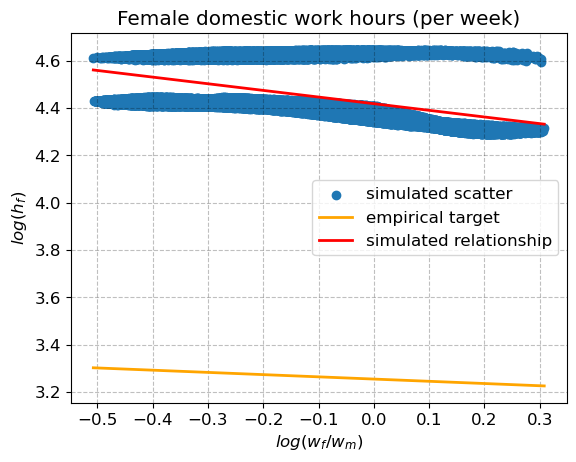

In [24]:
print(model.par)
model.plot_female_hours()

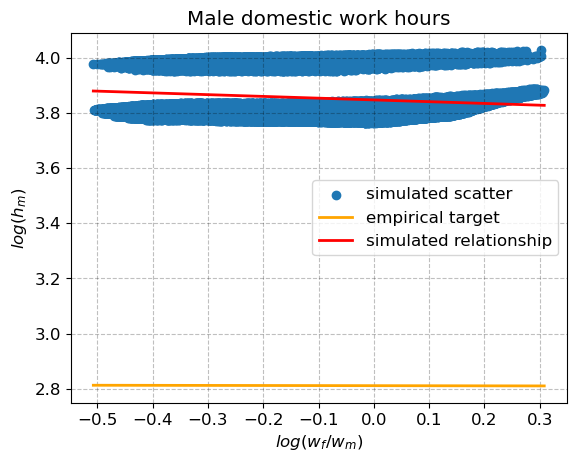

In [25]:
model.plot_male_hours()

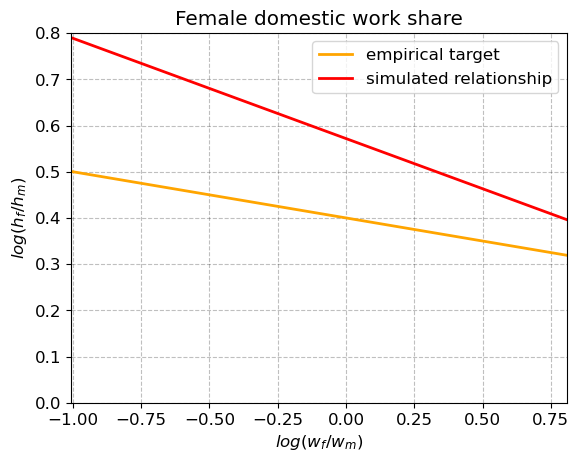

In [26]:
model.plot()

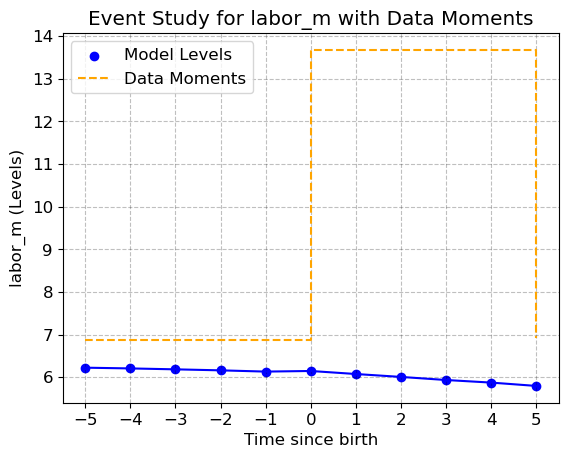

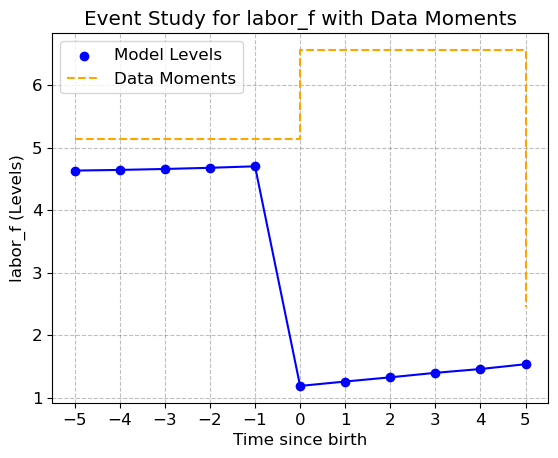

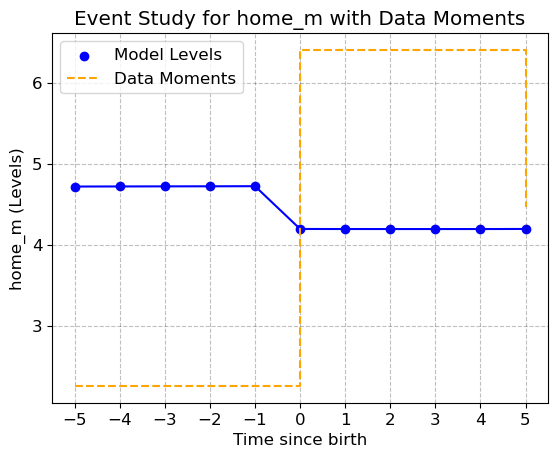

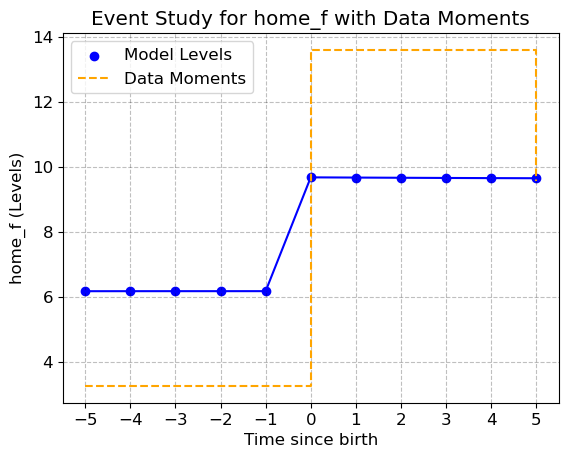

In [52]:
# Map variable names for data moments
moment_map = {
    'labor_m': ('pre_l_m', 'jump_l_m', 'post_l_m'),
    'labor_f': ('pre_l_f', 'jump_l_f', 'post_l_f'),
    'home_m': ('pre_h_m', 'jump_h_m', 'post_h_m'),
    'home_f': ('pre_h_f', 'jump_h_f', 'post_h_f')
}

# Load data moments
data_moments = pd.read_csv("Moments_Data.csv")

for val in ('labor_m', 'labor_f', 'home_m', 'home_f'):
    # Get event study data from the model
    event_grid, event_rel = calculate_event_mean_new(model, val, min_time=-5, max_time=5)

    # Get data moments for the current variable
    data_pre = data_moments.loc[0, moment_map[val][0]]
    data_jump = data_moments.loc[0, moment_map[val][1]]
    data_post = data_moments.loc[0, moment_map[val][2]]

    # Define x-axis points for the step function
    data_x = [-5, 0, 0, 5]
    data_y = [data_pre, data_pre, data_pre + data_jump, data_post]

    # Create the figure
    fig, ax = plt.subplots()

    # Plot the event study (model levels)
    ax.scatter(event_grid, event_rel, color='blue', label='Model Levels')
    ax.plot(event_grid, event_rel, color='blue', linestyle='-')

    # Add data moments step function
    ax.step(data_x, data_y, where='post', color='orange', label='Data Moments', linestyle='--')

    # Set titles and labels
    ax.set(title=f'Event Study for {val} with Data Moments',
           xlabel='Time since birth',
           ylabel=f'{val} (Levels)',
           xticks=event_grid)

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()


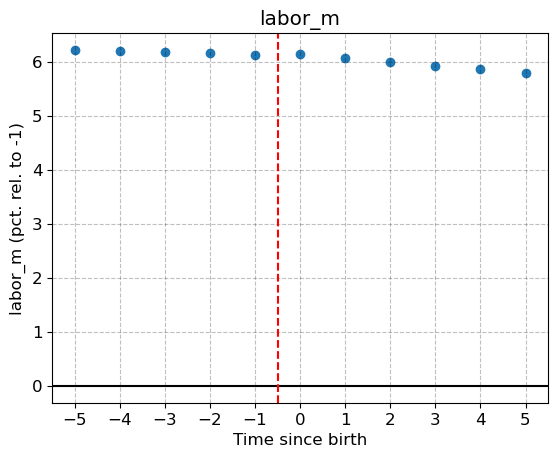

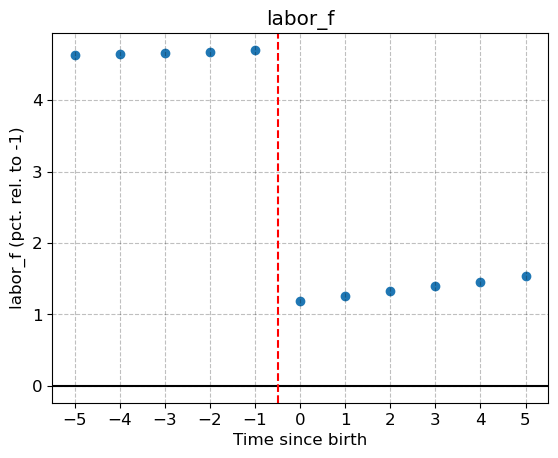

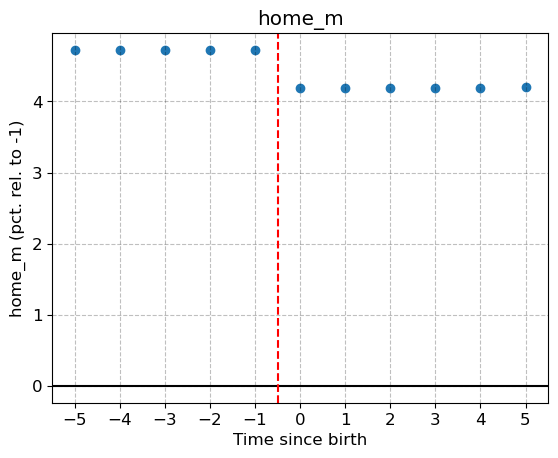

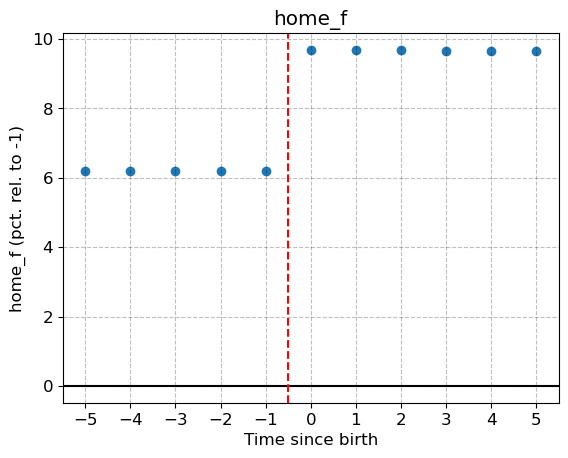

In [46]:
# since the model-object already has the estimated parameters updated, we can now plot the model fit

for val in ('labor_m','labor_f','home_m','home_f'):
        
    event_grid,event_rel = calculate_event_mean_new(model,val,min_time=-5,max_time=5)

    fig, ax = plt.subplots()
    ax.scatter(event_grid,event_rel)
   
    ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} (pct. rel. to -1)',xticks=event_grid);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


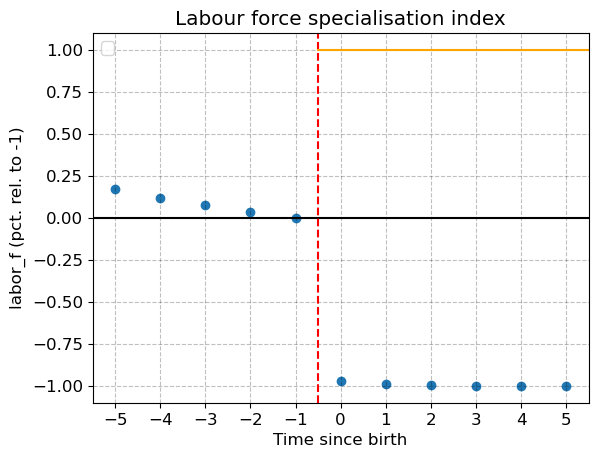

In [28]:
fig, ax = plt.subplots()
ax.scatter(event_grid, event_rel)
ax.axhline(y=0, color='black')
ax.axvline(x=-0.5, color='red', linestyle='dashed')

# Plot the orange line only when the x-axis value is greater than -0.5
# We'll check where event_grid is greater than -0.5 and limit the axhline accordingly

if any(event_grid > -0.5):
    ax.axhline(y=1, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid))

ax.set(title='Labour force specialisation index', xlabel='Time since birth', ylabel=f'{val} (pct. rel. to -1)', xticks=event_grid)

#Show the legend
ax.legend()

plt.show()


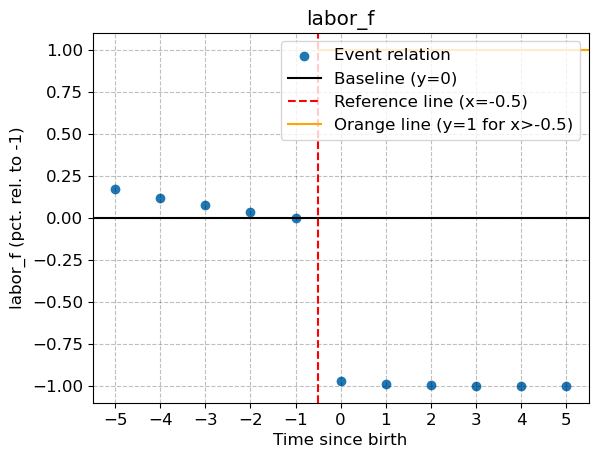

In [29]:
fig, ax = plt.subplots()

# Scatter plot for the event-related data
ax.scatter(event_grid, event_rel, label='Event relation')
ax.axhline(y=0, color='black', label='Baseline (y=0)')
ax.axvline(x=-0.5, color='red', linestyle='dashed', label='Reference line (x=-0.5)')

# Plot the orange line only when the x-axis value is greater than -0.5
if any(event_grid > -0.5):
    ax.axhline(y=1, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid), label='Orange line (y=1 for x>-0.5)')

# Set title, labels, and ticks
ax.set(title=val, xlabel='Time since birth', ylabel=f'{val} (pct. rel. to -1)', xticks=event_grid)

# Show the legend
ax.legend()

plt.show()


## Question 11

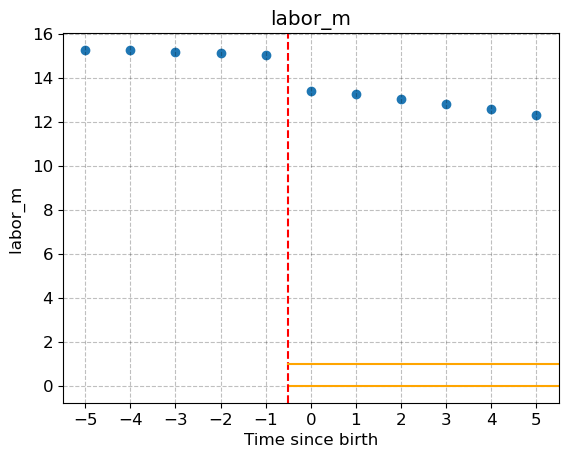

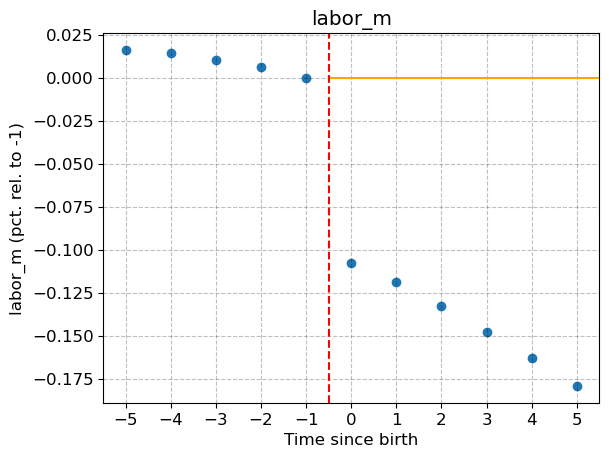

In [30]:
for relative in (None,-1):
    for val in ('labor_m',):
            
        event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=relative,pct=True)
        
        rel = ''
        if relative is not None:
            rel = '(pct. rel. to -1)'
        
        if any(event_grid > -0.5):
            ax.axhline(y=1, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid))
        fig, ax = plt.subplots()
        ax.scatter(event_grid,event_rel)
        if any(event_grid > -0.5):
            ax.axhline(y=0.0, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid))
        #ax.axhline(y=0,color='black')
        ax.axvline(x=-0.5,color='red',linestyle='dashed')
        ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} {rel}',xticks=event_grid);

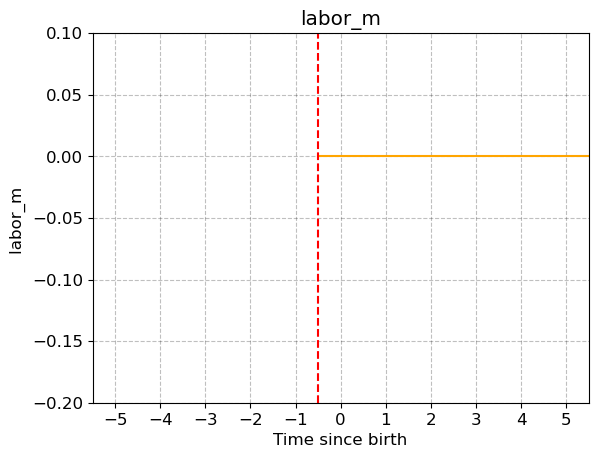

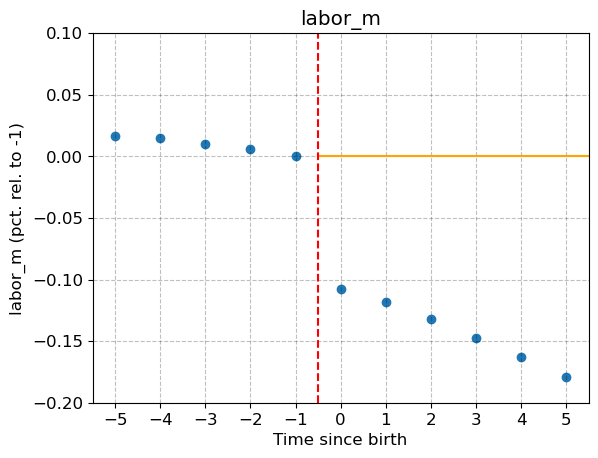

In [31]:
for relative in (None, -1):
    for val in ('labor_m',):
            
        event_grid, event_rel = calculate_event_mean(model, val, min_time=-5, max_time=5, relative=relative, pct=True)
        
        rel = ''
        if relative is not None:
            rel = '(pct. rel. to -1)'
        
        fig, ax = plt.subplots()
        ax.scatter(event_grid, event_rel)
        
        if any(event_grid > -0.5):
            ax.axhline(y=0.0, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid))
        
        # Vertical line at x=-0.5
        ax.axvline(x=-0.5, color='red', linestyle='dashed')
        
        # Set y-axis limits
        ax.set_ylim(-0.2, 0.1)
        
        # Set title and labels
        ax.set(title=val, xlabel='Time since birth', ylabel=f'{val} {rel}', xticks=event_grid)


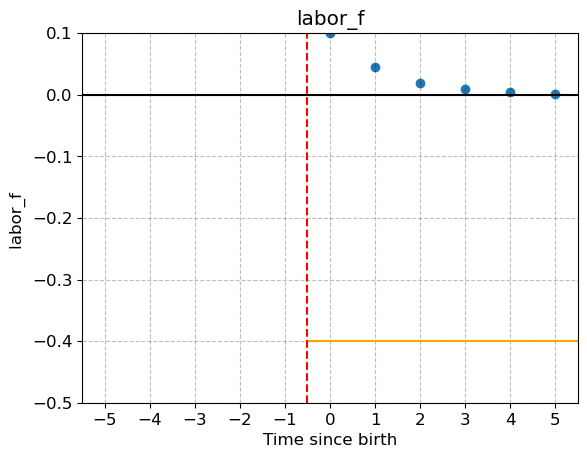

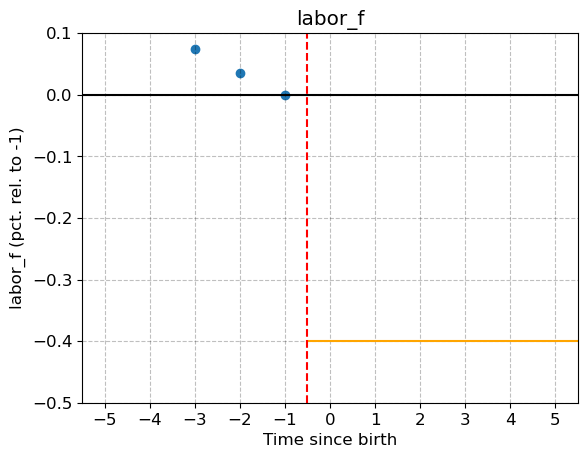

In [32]:
for relative in (None,-1):
    for val in ('labor_f',):
            
        event_grid,event_rel = calculate_event_mean(model,val,min_time=-5,max_time=5,relative=relative,pct=True)
        
        rel = ''

        
        if relative is not None:
            rel = '(pct. rel. to -1)'
        fig, ax = plt.subplots()
        ax.scatter(event_grid,event_rel)

        if any(event_grid > -0.5):
            ax.axhline(y=-0.4, color='orange', xmin=(event_grid > -0.5).argmax() / len(event_grid))

        # Set y-axis limits
        ax.set_ylim(-0.5, 0.1)
        ax.axhline(y=0,color='black')
        ax.axvline(x=-0.5,color='red',linestyle='dashed')
        ax.set(title=val,xlabel='Time since birth',ylabel=f'{val} {rel}',xticks=event_grid);

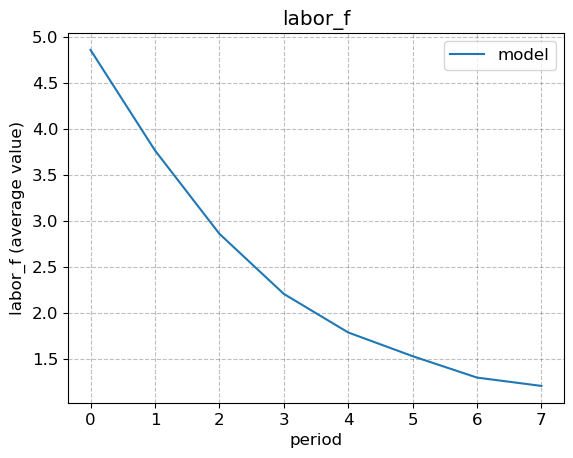

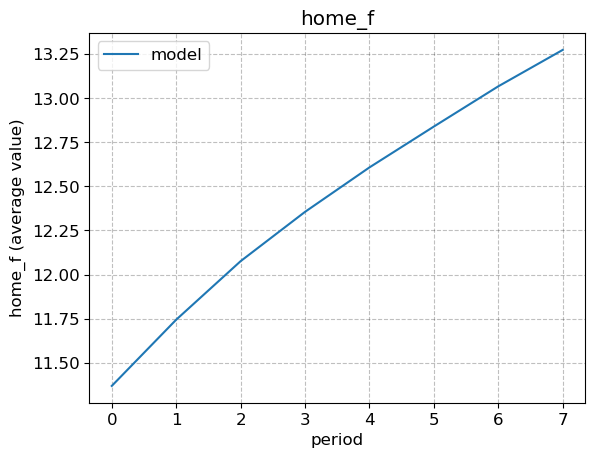

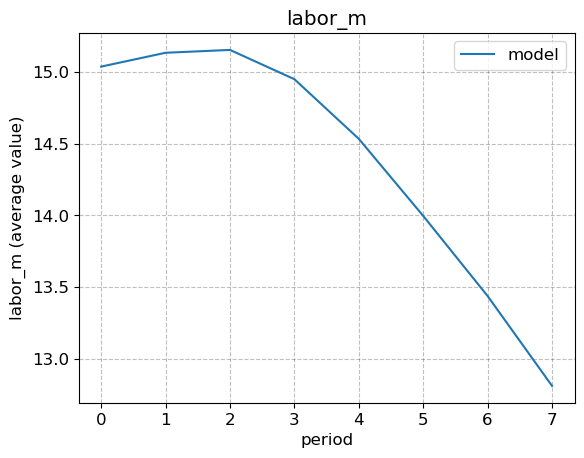

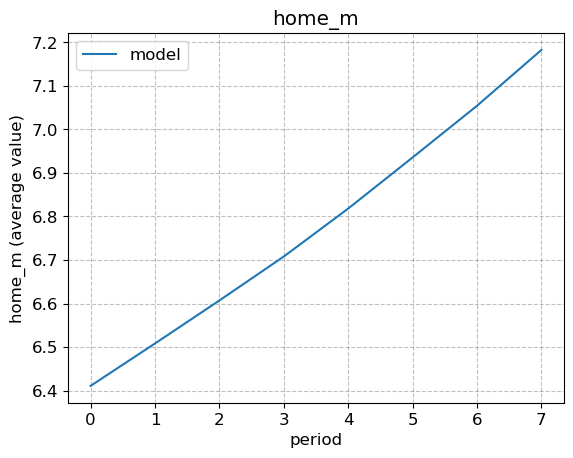

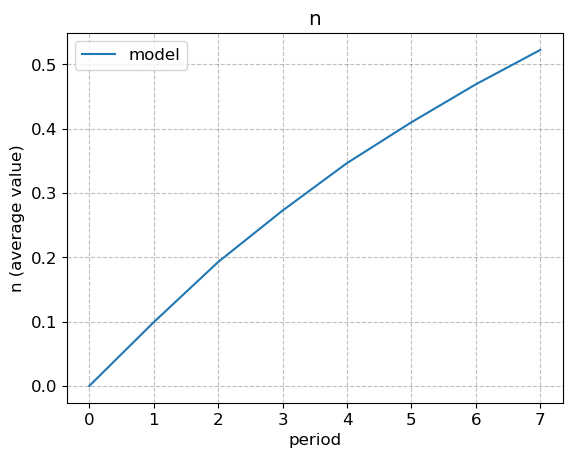

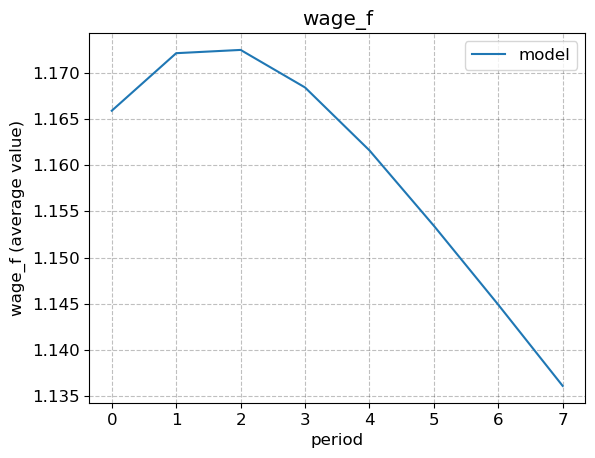

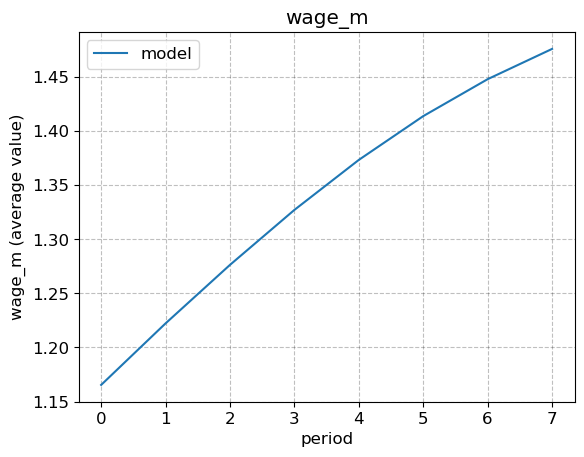

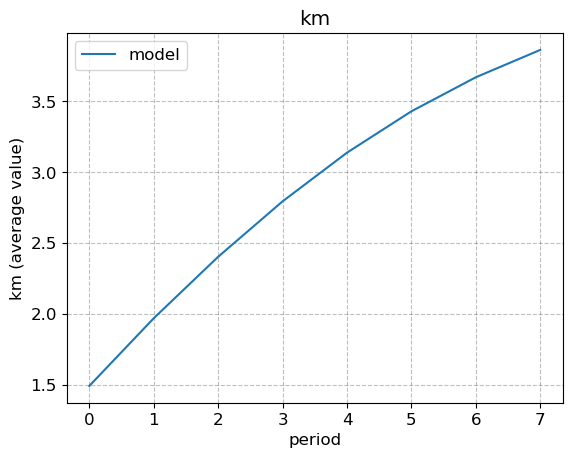

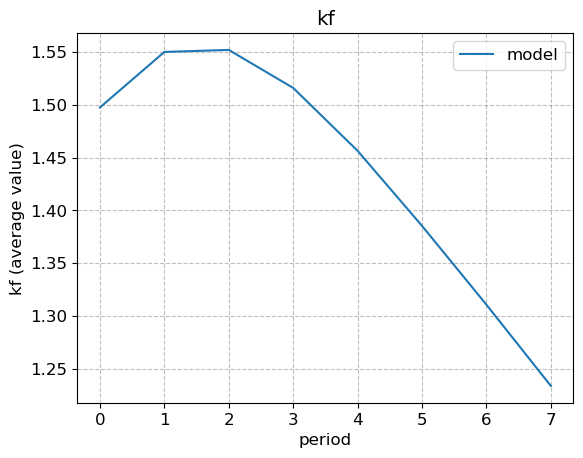

In [33]:
# plot simulated behviour over time

for outcome in ('labor_f','home_f','labor_m','home_m','n', 'wage_f', 'wage_m', 'km', 'kf'):
    fig, ax = plt.subplots()
    outcome_values = np.mean(getattr(model.sim, outcome), axis=0)  # Renamed the variable to avoid confusion
    
    ax.plot(outcome_values, label='model')
    ax.set(title=outcome, xlabel='period', ylabel=f'{outcome} (average value)')  # Set outcome name as title
    ax.legend()


In [34]:
np.exp(3.5)

33.11545195869231

## Counterfactuals

In [35]:
# 10% increase in wage_hum_cap_f
model_reform_f_10pct = model.copy()
model_reform_f_10pct.par.wage_humcap_f = model.par.wage_humcap_f*1.1

#10% increase in wage_const_f
model_reform_f_const_10pct = model.copy()
model_reform_f_const_10pct.par.wage_const_f = model.par.wage_const_f*1.1

# increase of 0.01 in X 
model_reform_X = model.copy()
model_reform_X.par.X = model.par.X + 0.05

# 10% increase in female power
model_patriarchy = model.copy()
model_patriarchy.par.power = model.par.power * 1.1



In [36]:
# solve hum cap wage reform
#model_reform_f_10pct.solve()
#model_reform_f_10pct.simulate()

# solve constant wage reform
model_reform_f_const_10pct.solve()
model_reform_f_const_10pct.simulate()

# solve X reform
model_reform_X.solve()
model_reform_X.simulate()

# solve patriarchy reform
#model_patriarchy.solve()
#model_patriarchy.simulate()


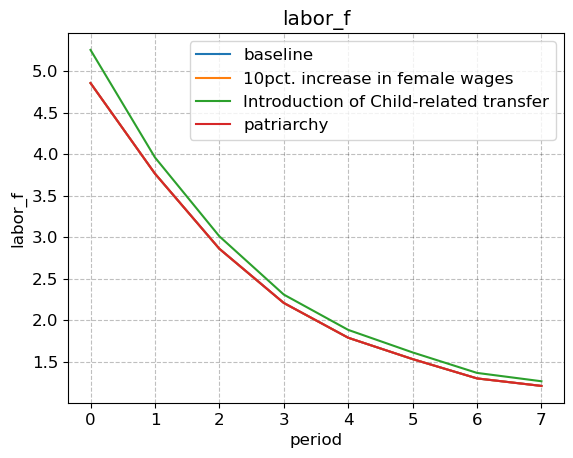

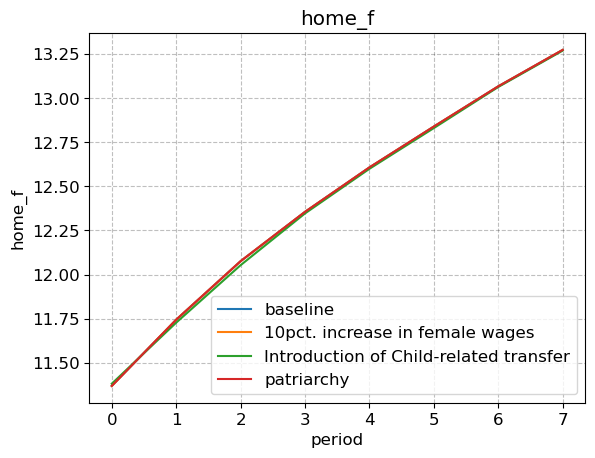

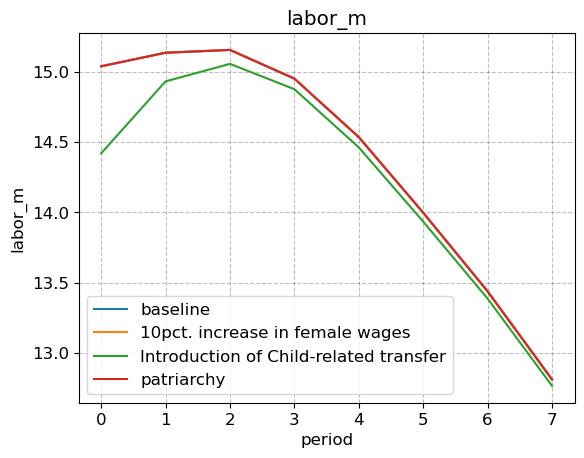

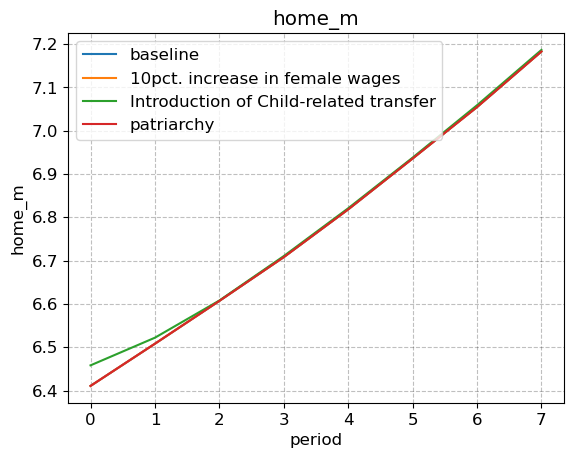

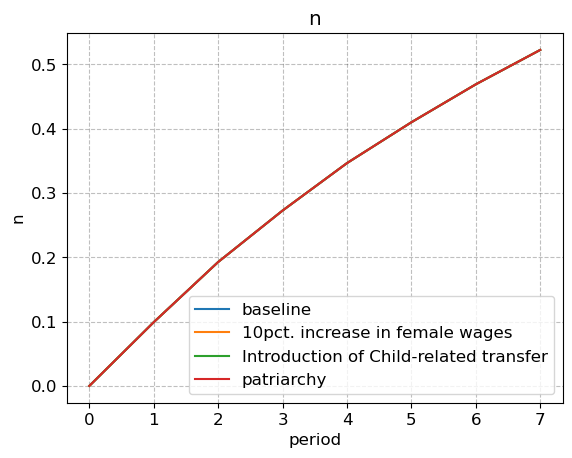

In [37]:
for outcome in ('labor_f','home_f','labor_m','home_m','n'):
    fig, ax = plt.subplots()
    outcome_baseline = np.mean(getattr(model.sim, outcome), axis=0)
    outcome_reform_f = np.mean(getattr(model_reform_f_10pct.sim, outcome), axis=0)
    
    # Check if 'model_reform_f_const_10pct' exists
    if 'model_reform_f_const_10pct' in globals():
        outcome_reform_f_const_f = np.mean(getattr(model_reform_f_const_10pct.sim, outcome), axis=0)
    else:
        print("model_reform_f_const_10pct not defined")
    
    # Plot the available data
    ax.plot(outcome_baseline, label='baseline')
    ax.plot(outcome_reform_f, label='10pct. increase in female wages')
    
    # Only plot reform_const_f if available
    #if 'outcome_reform_f_const_f' in locals():
        #ax.plot(outcome_reform_f_const_f, label='reform_const_f')

    # plot X reform if available
    if 'model_reform_X' in globals():
        outcome_reform_X = np.mean(getattr(model_reform_X.sim, outcome), axis=0)
        ax.plot(outcome_reform_X, label='Introduction of Child-related transfer')

    # plot patriarchy reform if available
    #if 'model_patriarchy' in globals():
        outcome_patriarchy = np.mean(getattr(model_patriarchy.sim, outcome), axis=0)
        ax.plot(outcome_patriarchy, label='patriarchy')

    ax.set(title=outcome, xlabel='period', ylabel=outcome)
    ax.legend()


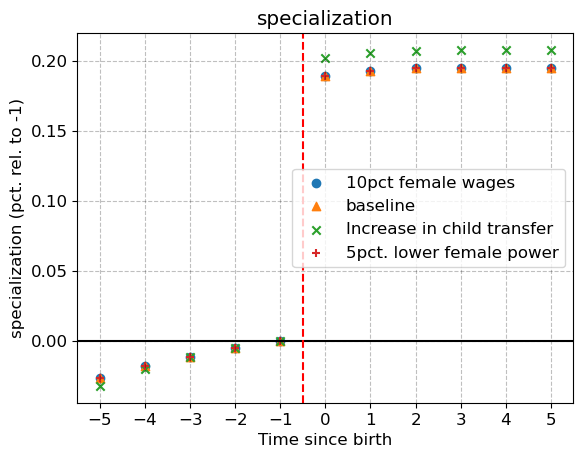

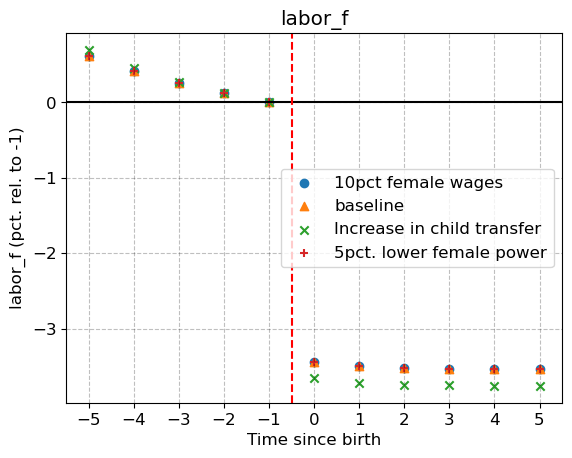

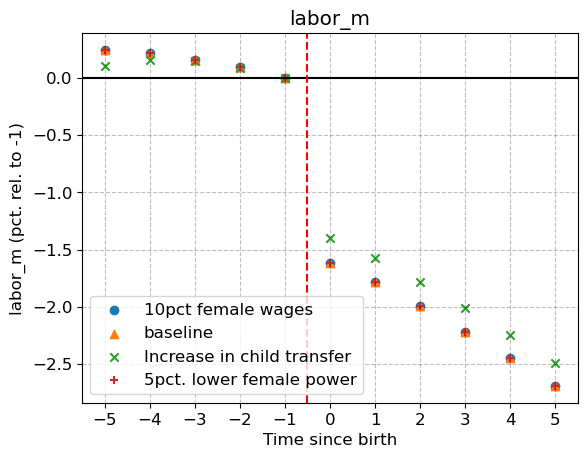

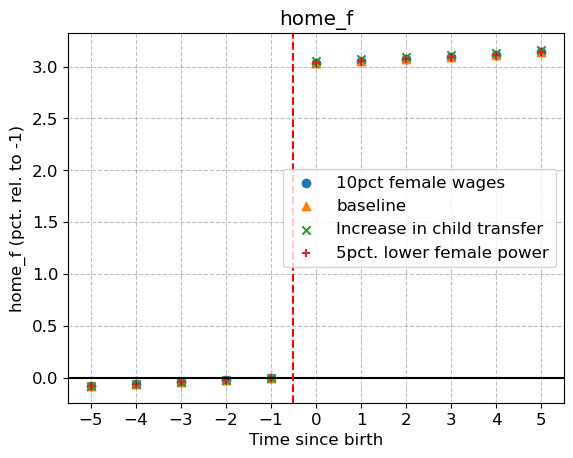

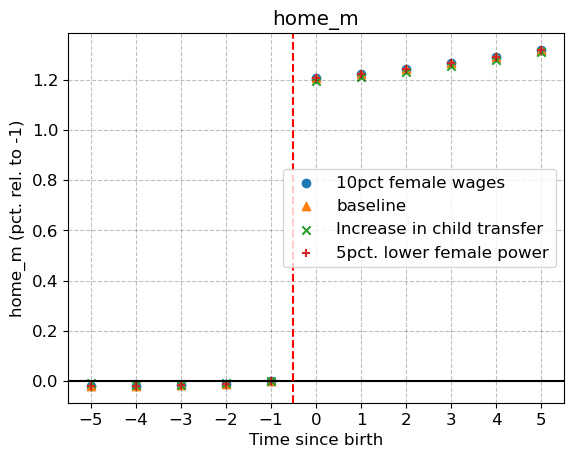

In [38]:
for val in ('specialization','labor_f', 'labor_m', 'home_f', 'home_m'):
        
    event_grid, event_rel = calculate_event_mean(model_reform_f_10pct, val, min_time=-5, max_time=5, relative=-1, pct=False)
    event_grid_baseline, event_rel_baseline = calculate_event_mean(model, val, min_time=-5, max_time=5, relative=-1, pct=False)
    event_grid_const, event_rel_const = calculate_event_mean(model_reform_f_const_10pct, val, min_time=-5, max_time=5, relative=-1, pct=False)
    event_grid_X, event_rel_X = calculate_event_mean(model_reform_X, val, min_time=-5, max_time=5, relative=-1, pct=False)
    event_grid_patriarchy, event_rel_patriarchy = calculate_event_mean(model_patriarchy, val, min_time=-5, max_time=5, relative=-1, pct=False)

    fig, ax = plt.subplots()

    # Plotting 10% female wages with circle markers
    ax.scatter(event_grid, event_rel, label='10pct female wages', marker='o')

    # Plotting increase in wage const with square markers
    #ax.scatter(event_grid_const, event_rel_const, label='increase wage const female', marker='s')

    # Plotting baseline with triangle markers
    ax.scatter(event_grid_baseline, event_rel_baseline, label='baseline', marker='^')

    # Plotting X reform with marker x
    ax.scatter(event_grid_X, event_rel_X, label='Increase in child transfer', marker='x')

    # plot patriarchy reform with marker +
    ax.scatter(event_grid_patriarchy, event_rel_patriarchy, label='5pct. lower female power', marker='+')


    ax.axhline(y=0, color='black')
    ax.axvline(x=-0.5, color='red', linestyle='dashed')

    ax.set(title=val, xlabel='Time since birth', ylabel=f'{val} (pct. rel. to -1)', xticks=event_grid)
    
    # Display legend
    ax.legend()
